Mahad Imran
366569

In [1]:
!pip install tensorflow
!pip install --upgrade keras

# Visualization
import matplotlib.pyplot as plt
import numpy as np
# Model training
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Lambda, BatchNormalization, ReLU, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Loading data

In [2]:
from sklearn.datasets import fetch_olivetti_faces
# Load the Olivetti faces dataset
faces = fetch_olivetti_faces()
# Extract the images and expand their dimensions to include a channel dimension
X = faces.images
X = np.expand_dims(X, axis=-1)

# Extract the labels
y = faces.target
# Print the shape of the data
print(f'Shape of X (features): {X.shape}')
print(f'Shape of y (labels): {y.shape}')

# Get the of occurances of each label
unique_labels, _ = np.unique(y, return_counts=True)

# Get image shape
IMG_SHAPE = X[0].shape
print(f"IMG_SHAPE = ", IMG_SHAPE)

# Print the labels of the individuals
print(unique_labels)

Shape of X (features): (400, 64, 64, 1)
Shape of y (labels): (400,)
IMG_SHAPE =  (64, 64, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


# Creating pairs

In [12]:
# Select a subset of 5 individuals with 5 images each
individuals = np.unique(y)[:5]  # Take first 5 individuals
indices = []

for person in individuals:
    person_indices = np.where(y == person)[0][:5]  # Take first 5 images of each person
    indices.extend(person_indices)

X_subset = X[indices]
y_subset = y[indices]

print(f"Subset shape: {X_subset.shape}")
print(f"Subset labels: {np.unique(y_subset)}")

# This function creates an equal amount of randomly selected positive and negative pairs
# Given the images, their labels, the list of unique labels, and the number of pairs to create,
# it returns two numpy arrays containing pairs of images and their labels (1 for similar, 0 for different)
# Generate pairs
def create_pairs(x, y):
    """Create positive and negative pairs."""
    pairs = []
    labels = []

    # Dictionary mapping class indices to sample indices
    class_indices = {}
    for i, label in enumerate(y):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(i)

    # For each class (person)
    for d in class_indices:
        for i in range(len(class_indices[d])):
            # Positive pairs (same person)
            for j in range(i + 1, len(class_indices[d])):
                pairs.append([x[class_indices[d][i]], x[class_indices[d][j]]])
                labels.append(1)  # 1 means same person

            # Negative pairs (different people)
            for dn in [k for k in class_indices.keys() if k != d]:
                for j in range(len(class_indices[dn])):
                    pairs.append([x[class_indices[d][i]], x[class_indices[dn][j]]])
                    labels.append(0)  # 0 means different person

    return np.array(pairs), np.array(labels)

pairs, pair_labels = create_pairs(X_subset, y_subset)

Subset shape: (25, 64, 64, 1)
Subset labels: [0 1 2 3 4]


In [6]:
# This function splits an array into training and testing subarrays based on a training size percentage.
# It is used later to split the data based on the unique labels present, so that 30 people's images
# are used for training, and 10 people's images are used for one-shot trials.
def split_array(array, percentage):
    # Ensure the percentage is valid
    if not 0 <= percentage <= 1:
        raise ValueError("Percentage must be between 0 and 1.")

    # Calculate the number of elements for the split
    split_size = int(len(array) * percentage)

    # Split the array in order without shuffling
    train_part = array[:split_size]
    test_part = array[split_size:]

    return train_part, test_part

In [22]:
# Split the unique labels from the subset for training and testing
unique_labels_subset = np.unique(y_subset)
unique_labels_train, unique_labels_test = split_array(unique_labels_subset, 0.8)

pairs_train = pairs
labels_train = pair_labels

print(f'Unique identities in the subset used for creating pairs: {unique_labels_subset}')
print(f'Number of training pairs using the subset: {len(pairs_train)}')

Unique identities in the subset used for creating pairs: [0 1 2 3 4]
Number of training pairs using the subset: 550


# Visualize data

In [23]:
# First image in each pair
X1_train = np.array([pair[0] for pair in pairs_train])
# Second image in each pair
X2_train = np.array([pair[1] for pair in pairs_train])

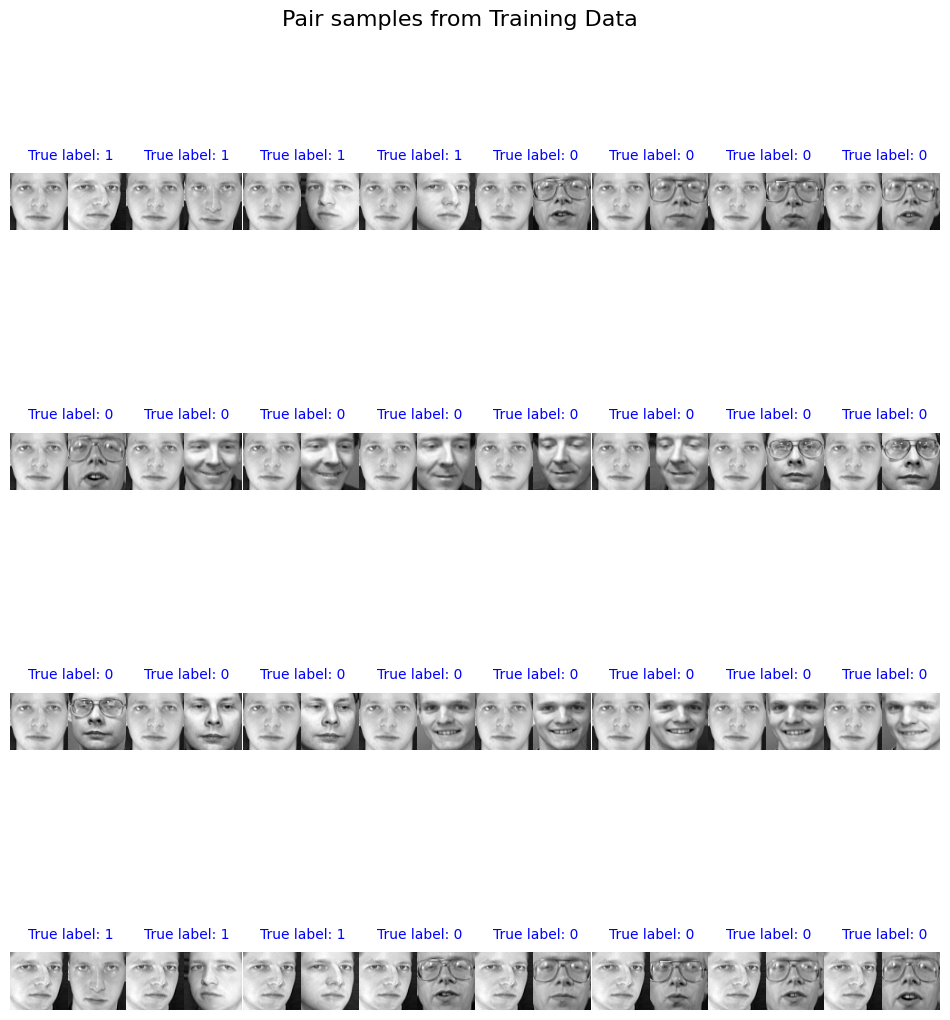

In [25]:
# This function visualizes a subset of the pairs used in the data
def visualize_pairs(X1,X2,y,num_pairs,pairs_per_row, title="Pair samples from Training Data",labels_title="True label",padding=10):
    if pairs_per_row == 0:
        return
    rows = num_pairs // pairs_per_row

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(rows, pairs_per_row * 2, figsize=(12, 3 * rows))
    fig.subplots_adjust(wspace=0.01, hspace=0.8)  # Minimal space between images in a pair; more between rows

    # Plot each pair with its label
    for i in range(num_pairs):
        row = i // pairs_per_row
        col = (i % pairs_per_row) * 2  # Each pair occupies two columns

        # Display the first image of the pair (X1_train[i])
        axes[row, col].imshow(X1[i], cmap='gray')  # Adjust cmap as needed
        axes[row, col].axis('off')

        # Display the second image of the pair (X2_train[i])
        axes[row, col + 1].imshow(X2[i], cmap='gray')  # Adjust cmap as needed
        axes[row, col + 1].axis('off')

        # Add the label above the pair, centered
        label = f"{labels_title}: {y[i]}"
        axes[row, col].set_title(label, fontsize=10, color="blue", pad=padding, loc='center', x=1.05)
        axes[row, col + 1].set_title("")  # Empty title for the second image in each pair

    plt.suptitle(title, fontsize=16)
    plt.show()

#visualize_pairs(X1_train, X2_train, labels_train,32,8)


# CNN

In [29]:
from tensorflow.keras.regularizers import l2

# This function was created to experiment with different parameters and structures for the feature extraction
# layers, which I refer to here as cnn_part. This allowed me to find the most optimal complexity of the feature
# extraction layers for my task, and facilitated keeping track of experiments. At the end, architecture C
# provided the best results, so I ended up saving that as the structure of my model, and the reported
# results follow that structure.
def create_model(architecture, IMG_SHAPE):
    cnn_part = Sequential()

    if architecture == 'A':
        # Architecture A
        cnn_part.add(Conv2D(filters=64, kernel_size=(10, 10), input_shape=IMG_SHAPE, kernel_regularizer=l2(2e-4)))
        cnn_part.add(BatchNormalization())
        cnn_part.add(ReLU())
        cnn_part.add(MaxPooling2D(pool_size=(2, 2)))
        cnn_part.add(Dropout(0.3))

        cnn_part.add(Conv2D(128, (7, 7), strides=1, kernel_regularizer=l2(2e-4)))
        cnn_part.add(BatchNormalization())
        cnn_part.add(ReLU())
        cnn_part.add(MaxPooling2D(pool_size=(2, 2)))
        cnn_part.add(Dropout(0.3))

        cnn_part.add(Conv2D(256, (4, 4), strides=1, kernel_regularizer=l2(2e-4)))
        cnn_part.add(BatchNormalization())
        cnn_part.add(ReLU())
        cnn_part.add(MaxPooling2D(pool_size=(2, 2)))
        cnn_part.add(Dropout(0.3))

        cnn_part.add(Flatten())
        cnn_part.add(BatchNormalization())
        cnn_part.add(Dense(128, activation="sigmoid"))

    elif architecture == 'B':
        # Architecture B: Similar but with different kernel sizes and more layers
        cnn_part.add(Conv2D(filters=32, kernel_size=(5, 5), input_shape=IMG_SHAPE, kernel_regularizer=l2(2e-4)))
        cnn_part.add(BatchNormalization())
        cnn_part.add(ReLU())
        cnn_part.add(MaxPooling2D(pool_size=(2, 2)))
        cnn_part.add(Dropout(0.3))

        cnn_part.add(Conv2D(64, (5, 5), strides=1, kernel_regularizer=l2(2e-4)))
        cnn_part.add(BatchNormalization())
        cnn_part.add(ReLU())
        cnn_part.add(MaxPooling2D(pool_size=(2, 2)))
        cnn_part.add(Dropout(0.3))

        cnn_part.add(Flatten())
        cnn_part.add(BatchNormalization())
        cnn_part.add(Dense(128, activation="sigmoid"))

    elif architecture == 'C':
        # Architecture C: Adding more depth
        cnn_part.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=IMG_SHAPE, kernel_regularizer=l2(2e-4)))
        cnn_part.add(BatchNormalization())
        cnn_part.add(ReLU())
        cnn_part.add(MaxPooling2D(pool_size=(2, 2)))
        cnn_part.add(Dropout(0.3))

        cnn_part.add(Conv2D(256, (3, 3), strides=1, kernel_regularizer=l2(2e-4)))
        cnn_part.add(BatchNormalization())
        cnn_part.add(ReLU())
        cnn_part.add(MaxPooling2D(pool_size=(2, 2)))
        cnn_part.add(Dropout(0.3))

        cnn_part.add(Flatten())
        cnn_part.add(BatchNormalization())
        cnn_part.add(Dense(128, activation="sigmoid"))

    elif architecture == 'D':
        # Architecture D: Global Average Pooling instead of Flatten
        cnn_part.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=IMG_SHAPE, kernel_regularizer=l2(2e-4)))
        cnn_part.add(BatchNormalization())
        cnn_part.add(ReLU())
        cnn_part.add(MaxPooling2D(pool_size=(2, 2)))
        cnn_part.add(Dropout(0.3))

        cnn_part.add(Conv2D(128, (3, 3), strides=1, kernel_regularizer=l2(2e-4)))
        cnn_part.add(BatchNormalization())
        cnn_part.add(ReLU())
        cnn_part.add(MaxPooling2D(pool_size=(2, 2)))
        cnn_part.add(Dropout(0.3))

        cnn_part.add(Conv2D(256, (3, 3), strides=1, kernel_regularizer=l2(2e-4)))
        cnn_part.add(BatchNormalization())
        cnn_part.add(ReLU())
        cnn_part.add(MaxPooling2D(pool_size=(2, 2)))
        cnn_part.add(Dropout(0.3))

        # Add Global Average Pooling instead of Flatten
        cnn_part.add(GlobalAveragePooling2D())

        cnn_part.add(BatchNormalization())
        cnn_part.add(Dense(128, activation="sigmoid"))

    return cnn_part



In [30]:
import os
# Set parameters
IMG_SHAPE = (64, 64, 1)  # Input shape for images
# Final chosen architecture
architecture = 'C'
# Batch size
batch_sizes = [32]  # Batch sizes to test
epochs = 8  # Number of epochs to train

folder_path = f"trained_model"
# Create output directory if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [31]:
# Import necessary modules for optimizer and early stopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Print information about the current training configuration
print(f"Training the architecture {architecture} with batch size {32}")

# Create the CNN subnetwork for the Siamese model using architecture "C"
cnn_part = create_model(architecture, IMG_SHAPE)

# Define two input layers for the pair of input images
input1, input2 = Input(shape=IMG_SHAPE, name="Image1"), Input(shape=IMG_SHAPE, name="Image2")

# Pass both inputs through the shared CNN model to get their embeddings
embedding1, embedding2 = cnn_part(input1), cnn_part(input2)

# Calculate the absolute difference between the two embeddings
distance = Lambda(lambda tensors: abs(tensors[0] - tensors[1]))([embedding1, embedding2])

# Pass the distance through a Dense layer with sigmoid activation to get similarity score
final_output = Dense(1, activation='sigmoid')(distance)

# Create the full Siamese model
snn = Model(inputs=[input1, input2], outputs=final_output)

# Compile the model with Adam optimizer and binary cross-entropy loss
snn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=None)

# Define early stopping to halt training when validation performance stops improving
es = EarlyStopping(patience=3)

# Train the model on the training pairs
snn.fit(x=[X1_train, X2_train],
        y=labels_train,
        batch_size=32,
        epochs=epochs,
        callbacks=[es],
        shuffle=True)

# Define the filename and save the trained model
model_filename = f"{folder_path}/snn_final.h5"
snn.save(model_filename)

# confirm that the model was saved
print(f"Model saved to {model_filename}")


Training the architecture C with batch size 32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - loss: 0.6419
Epoch 2/8


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - loss: 0.2500
Epoch 3/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - loss: 0.1570
Epoch 4/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - loss: 0.1243
Epoch 5/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - loss: 0.1143
Epoch 6/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - loss: 0.1014
Epoch 7/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - loss: 0.0896
Epoch 8/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - loss: 0.0818


Model saved to trained_model/snn_final.h5


In [37]:
def compute_accuracy(snn_model, test_pairs, test_labels, threshold=0.5):
    # Separate the pairs into two lists of images
    X1_test = np.array([pair[0] for pair in test_pairs])
    X2_test = np.array([pair[1] for pair in test_pairs])

    # Predict the similarity scores for the test pairs
    predictions = snn_model.predict([X1_test, X2_test])

    # Convert the predicted scores to binary predictions based on the threshold
    binary_predictions = (predictions > threshold).astype(int)

    # Compare the binary predictions with the true labels
    correct_predictions = np.sum(binary_predictions.flatten() == test_labels)

    # Calculate accuracy as a percentage
    accuracy = (correct_predictions / len(test_labels)) * 100

    return accuracy

# Calculate the accuracy
accuracy = compute_accuracy(snn, pairs_test, labels_test)

print(f"Accuracy of the trained model on the test data: {accuracy:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 880ms/step
Accuracy of the trained model on the test data: 89.82%
